In [ ]:
## Convolutional Neural Networks
如果您想将机器学习应用于图像识别，那么卷积神经网络（CNN）就是您的选择。在过去的几年里，它一直在席卷竞争对手，但也许它的第一次重大成功发生在90年代后期，当时Yann LeCun使用它以99.5％的准确度解决了MNIST。我将向您展示如何在Keras中完成它，这是一个用户友好的python神经网络库。

这里的许多其他笔记本使用简单的全连接网络（无卷积）来实现96-97％，这对该数据集来说效果不佳。相比之下，我将在这里向您展示的几乎是最先进的。在内核中（<20分钟训练），我们将达到99％，但如果你一夜之间训练（或使用GPU），你应该达到99.5。如果你在几次运行中进行模型的融合，你应该接近99.77％的最佳公布准确度。 （忽略排行榜上的100％结果;它们是通过重复提交来学习测试集而创建的）
开始：


如果您还没有Keras，可以通过conda或pip轻松安装。它依赖于tensorflow或theano，所以你应该先安装这些。 Keras已在内核和亚马逊深度学习AMI上提供。

In [1]:
#导入numpy包后续进行数据处理
import numpy as np # linear algebra

#导入matplotlib包后续进行画图
import matplotlib.pyplot as plt

#内嵌画图，使图像显示在该页面内
%matplotlib inline

#导入train_test_split包划分数据集为训练集，验证集
from sklearn.model_selection import train_test_split

#导入confusion_matrix(混淆矩阵)，查看真实值被正确或者错误预测的个数
from sklearn.metrics import confusion_matrix

In [2]:
#one-hot编码，采用独热码编码，直观来说就是有多少个状态就有多少比特，而且只有一个比特为1，其他全为0的一种码制，构造稀疏矩阵，解决分类值表示的问题对模型产生的负面影响
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

#导入顺序Sequential模型，后续可直接在Sequential上构建神经网络
from keras.models import Sequential

#Dense：全连接层；Dropout正则化数据；Flatten压平数据连接全连接层，Conv2D卷积层卷积计算，BatchNormalization数据规范化输出数据的均值接近0，其标准差接近1
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

#导入优化器Adam，基于一阶梯度的随机目标函数优化算法
from keras.optimizers import Adam

#导入ImageDataGenerator图像增广技术来扩充我们的数据集
from keras.preprocessing.image import ImageDataGenerator

#导入LearningRateScheduler动态修改学习率的回调函数
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [3]:
#根据自己所下载数据设置对应的路径
train_file = "/home/lqm/下载/kaggle/digit_data/digit-recognizer/train.csv"
test_file = "/home/lqm/下载/kaggle/digit_data/digit-recognizer/test.csv"
output_file = "/home/lqm/kaggle_result/submission.csv"

## 导入数据

与往常一样，我们将数据拆分为训练集和验证集，以便我们可以评估模型的性能。

In [4]:
#numpy导入数据，np.loadtxt
#loadtxt(fname, dtype=<class 'float'>, comments='#', delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
#fname要读取的文件、文件名、或生成器。
#dtype数据类型，默认float。
#comments注释。
#delimiter分隔符，默认是空格。
#skiprows跳过前几行读取，默认是0，必须是int整型。
#usecols：要读取哪些列，0是第一列。例如，usecols = （1,4,5）将提取第2，第5和第6列。默认读取所有列。
#unpack如果为True，将分列读取
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')



#划分数据集为训练集和验证集
#train_test_split(train_data,train_target,test_size=0.3, random_state=0)
#train_data：被划分的样本特征集
#train_target：被划分的样本标签
#test_size：如果是浮点数，在0-1之间，表示测试集样本占比；如果是整数的话就是样本的数量
#random_state：是随机数的种子,使每次产生的随机数一样
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

每个数据点由784个值组成。完全连接的网络只是将所有这些值视为相同，但CNN将其视为28x28平方。这两个图解释了差异：很容易理解为什么CNN可以获得更好的结果。

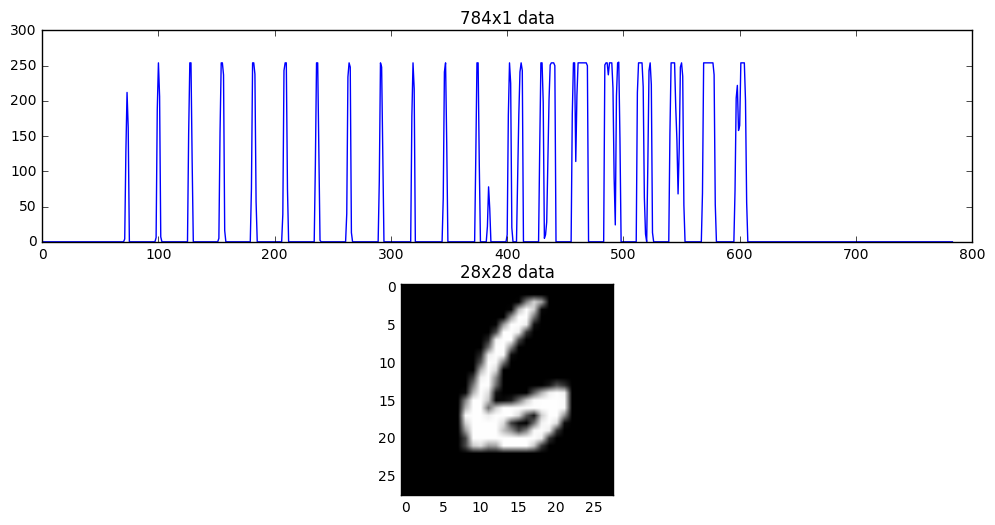

In [5]:
#subplots:子图显示，fig, ax = subplots(nrows, ncols，figsize）
#fig代表整个图像，ax代表坐标轴和画的图
#nrows，ncols：子图的行列数
#figsize：显示图形大小
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
#设置标题
ax[0].set_title('784x1 data')
#图形显示x_train数据
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
#设置标题
ax[1].set_title('28x28 data')

In [ ]:

我们现在以这种方式重塑所有数据。对于图片通道来说，Keras最终想要一个额外的维度。如果这是RGB图像，则会有3个通道，但由于MNIST是灰度级，它只使用一个。


In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1) （重塑三维图像）
#784个输入，转成28 * 28 + 颜色通道
#-1表示自动计算行数并填充
#注意keras的颜色通道表示在最后一个参数(跟其他框架不同)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

可以在原始数据上训练网络，像素值为0到255.但是，如果我们使用标准的权重初始化方法，0和1之间的数据应该使网络收敛更快。

In [7]:
#正则化数据，使矩阵内的数据规约到0到1之间，减少计算量，提升模型训练效率
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.


标签以0到9之间的整数给出。我们需要将它们转换为单热编码，即10x1数组，其中1和9为0：s，1的位置显示值。请参阅示例，1的位置显示上图中数字的正确值。

In [8]:
#to_categorical(data,num_classes)：one-hot编码(独热码编码)，在对应的标签置1，其余的全部为0,num_classes表示多少个标签
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#例如：2  −>−>  [0,0,1,0,0,0,0,0,0,0]
#example:
print(y_train[0])

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


## 训练模型

Keras提供了两种不同的网络定义方式。我们将使用Sequential API，您可以从输入开始一次添加一个图层。

最重要的部分是卷积层Conv2D。在这里，他们有16-32个滤波器，每个滤波器使用九个权重将像素转换为自身及其八个邻居的加权平均值。由于在整个图像上使用相同的九个权重，因此网络将获取在任何地方都有用的功能。由于它只有九个权重，我们可以将许多卷积层叠加在一起，而不会耗尽内存/时间。

MaxPooling图层只查看四个相邻像素并选取最大值。这将图像的大小减小了一半，并且通过组合卷积和池化层，网络能够组合其特征以学习图像的更多全局特征。最后，我们使用两个完全连接（密集）层中的功能。

批量标准化是一种技术手段，可以加快培训速度。 Dropout是一种正则化方法，其中该层随机地将每个训练样本的一部分权重替换为零。这迫使网络以分布式方式学习特征，而不是依赖于特定权重，因此改善了泛化。 'relu'是激活函数x  - > max（x，0）。

In [9]:
#定义顺序模型Sequential，Sequential是多个网络层的线性堆叠
#通常是由以下几层构成：数据输入层(Input)，卷积层(Convolutional)，池化层(Pooling)，全连接层(Dense)，数据输出层(Output)
model = Sequential()

#filters：整数，输出空间的维度（即卷积中滤波器的输出数量），滤波器做卷积计算用的，卷积计算的过程也正是图形匹配的过程。
#kernel_size：一个整数，或者单个整数表示的元组或列表，指明1D卷积窗口的长度（即卷积滤波器窗口大小）。
#activation：激活函数，relu激活函数是指让负数输出为0，正数原样输出。
#传递一个input_shape的关键字参数给第一层，input_shape是一个tuple类型的数据，其中也可以填入None，如果填入None则表示此位置可能是任何正整数。数据的batch大小不应包含在其中
#这里input_shape = (28, 28, 1)指28*28矩阵输入，1为颜色通道，灰色图则为1，rgb图则为3。
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))


#BatchNormalization：规范化，该层在每个批次上将前一层的激活值重新规范化，即使得其输出数据的均值接近0，其标准差接近1
#作用：（1）加速收敛（2）控制过拟合，可以少用或不用Dropout和正则（3）降低网络对初始化权重不敏感（4）允许使用较大的学习率
model.add(BatchNormalization())

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())


#MaxPooling图层只查看四个相邻像素并选取最大值。这将图像的大小减小了一半
#strides设置查看窗口大小，即在相邻的几个像素中做处理
model.add(MaxPool2D(strides=(2,2)))


#Dropout：正则化层，随机地将每个训练样本的一部分权重替换为零，简单一点说在前向传播的时候，让某个神经元的激活值以一定的概率p停止。下面补充Dropout工作原理
#作用：1.降低模型复杂度，增强模型的泛化能力，防止过拟合。2.降低了运算量。
model.add(Dropout(0.25))


model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

#Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到(Convolution)全连接层(Dense)的过渡。
#也就是说，Convolution卷积层之后是无法直接连接Dense全连接层的，需要把Convolution层的数据压平（Flatten）。
model.add(Flatten())
#Dense(512)表示output的shape为(*,32)
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

#Dense(10)表示output的shape为(*,10)，也就0-9的10个数字标签。
model.add(Dense(10, activation='softmax'))

## Dropout工作原理：
（1）首先随机（临时）删掉网络中一半的隐藏神经元，输入输出神经元保持不变。

（2）然后把输入x通过修改后的网络前向传播，然后把得到的损失结果通过修改的网络反向传播。一小批训练样本执行完这个过程后，在没有被删除的神经元上按照随机梯度下降法更新对应的参数（w，b）。

（3）然后继续重复这一过程：恢复被删掉的神经元（此时被删除的神经元保持原样，而没有被删除的神经元已经有所更新）
从隐藏层神经元中随机选择一个一半大小的子集临时删除掉（备份被删除神经元的参数）。
对一小批训练样本，先前向传播然后反向传播损失并根据随机梯度下降法更新参数（w，b） （没有被删除的那一部分参数得到更新，删除的神经元参数保持被删除前的结果）。



另一个改进泛化的重要方法是增强。这意味着通过随机扰动图像来生成更多训练数据。如果以正确的方式完成，它可以强制网络只学习翻译不变的功能。如果你在数百个时期训练这个模型，增强肯定会提高你的表现。在内核中，我们只会查看每个图像4-5次，因此差异较小。我们使用Keras函数进行扩充。

In [10]:
#图像增广技术扩充数据集
#zoom_range参数可以调整图片在长或宽的方向进行放大，这个参数可以是一个数或者是一个list。当给出一个数时，图片同时在长宽两个方向进行同等程度的放缩操作；当给出一个list时，则代表[width_zoom_range, height_zoom_range]，即分别对长宽进行不同程度的放缩。而参数大于0小于1时，执行的是放大操作，当参数大于1时，执行的是缩小操作
#width_shift_range是水平位置平移 。height_shift_range竖直位置平移。
#其参数可以是[0, 1]的浮点数，也可以大于1，但最好不要大于1，超出原图范围的区域大多效果不好，其最大平移距离为图片长或宽的尺寸乘以参数，同样平移距离并不固定为最大平移距离，平移距离在 [0, 最大平移距离] 区间内。
#rotation range的作用是用户指定旋转角度范围，其参数只需指定一个整数即可，可在 [0, 指定角度] 范围内进行随机角度旋转。
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

在培训开始之前，您需要编译模型。作为我们的损失函数，我们在Keras中使用了一个名为''categorical_crossentropy'的logloss。度量标准仅用于评估。作为优化器，我们可以使用正常的随机梯度下降（SGD），但Adam更快。

In [11]:
#API:model.compile(optimizer = '...', loss = '...', metrics = )
#优化器optimizer：该参数可指定为已预定义的优化器名，如rmsprop、adagrad，或一个Optimizer类的对象
#损失函数loss：该参数为模型试图最小化的目标函数，它可为预定义的损失函数名，如categorical_crossentropy、mse，也可以为一个损失函数。
#指标列表metrics：对分类问题，我们一般将该列表设置为metrics=[‘accuracy’]。指标可以是一个预定义指标的名字,也可以是一个用户定制的函数.指标函数应该返回单个张量,或一个完成metric_name - > metric_value映射的字典.

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])


我们以较小的学习率训练一次以确保收敛。然后我们加快速度，只是为了将每个时期的学习率降低10％。 Keras有这个功能：

In [12]:
#LearningRateScheduler动态修改学习率的回调函数，用于动态设置学习率，这里调用lambda函数
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)


我们将在训练期间使用非常小的验证集来节省内核中的时间。

In [13]:
#fit_generator模型的训练
#datagen.flow加载训练数据
# batch_size=None, #每经过多少个sample更新一次权重，defult 32
# epochs=1, #训练的轮数epochs
# verbose=1, #0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
# validation_data=None, #验证集
# steps_per_epoch=None, #将一个epoch分为多少个steps，也就是划分一个batch_size多大，比如steps_per_epoch=10，则就是将训练集分为10份，不能和batch_size共同使用
# validation_steps=None, #当steps_per_epoch被启用的时候才有用，验证集的batch_size
# callbacks=None,#list，list中的元素为keras.callbacks.Callback对象，在训练过程中会调用list中的回调函数

hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])
#训练集的正确率和误差：acc，loss
#验证集正确率和误差：val_acc，val_loss

Epoch 1/50
19s - loss: 0.8891 - acc: 0.7170 - val_loss: 0.1739 - val_acc: 0.9525
Epoch 2/50
22s - loss: 0.3416 - acc: 0.8949 - val_loss: 0.1262 - val_acc: 0.9575
Epoch 3/50
19s - loss: 0.2551 - acc: 0.9240 - val_loss: 0.0788 - val_acc: 0.9775
Epoch 4/50
18s - loss: 0.2034 - acc: 0.9389 - val_loss: 0.0651 - val_acc: 0.9800
Epoch 5/50
19s - loss: 0.2015 - acc: 0.9444 - val_loss: 0.0608 - val_acc: 0.9850
Epoch 6/50
18s - loss: 0.1627 - acc: 0.9482 - val_loss: 0.0489 - val_acc: 0.9825
Epoch 7/50
18s - loss: 0.1719 - acc: 0.9504 - val_loss: 0.0460 - val_acc: 0.9875
Epoch 8/50
19s - loss: 0.1444 - acc: 0.9594 - val_loss: 0.0219 - val_acc: 0.9900
Epoch 9/50
18s - loss: 0.1345 - acc: 0.9597 - val_loss: 0.0192 - val_acc: 0.9925
Epoch 10/50
18s - loss: 0.1215 - acc: 0.9639 - val_loss: 0.0409 - val_acc: 0.9875
Epoch 11/50
18s - loss: 0.1235 - acc: 0.9666 - val_loss: 0.0127 - val_acc: 0.9975
Epoch 12/50
20s - loss: 0.1090 - acc: 0.9674 - val_loss: 0.0134 - val_acc: 0.9950
Epoch 13/50
20s - loss: 0

## 评估

我们在训练期间仅使用了验证集的子集来节省时间。现在让我们检查整个验证集的性能。

In [14]:
#evaluate：模型评估，返回损失函数和指定的精确指标
#evaluate(self, x, y, batch_size=32, verbose=1, sample_weight=None)
#x_val：数据
#y_val：标签
#batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步
#verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
#sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
#修改输出格式
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0233, final accuracy: 0.9945


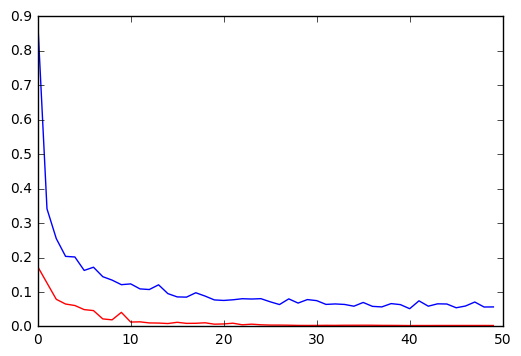

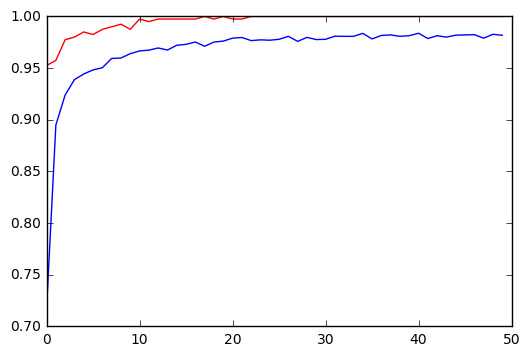

In [15]:
#hist.history包含val_loss,val_acc,loss,acc
#训练集的正确率和误差：acc，loss
#验证集正确率和误差：val_acc，val_loss
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [16]:
#模型的预测：predict(x, batch_size=None, verbose=0, steps=None, callbacks=None)
#x：输入数据，作为Numpy数组（如果模型有多个输入，则为Numpy数组列表）。
#batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步
#verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
#step：在宣布预测轮次结束之前的步骤总数（样本批次）
# callbacks=None,#list，list中的元素为keras.callbacks.Callback对象，在训练过程中会调用list中的回调函数
y_hat = model.predict(x_val)

#numpy.argmax(a, axis=None, out=None)，返回沿轴axis最大值的索引。
#a：数据
#axis = 1表示沿横轴，axis = 0表示沿纵轴
#返回取得最大值的索引
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)

#confusion_matrix(混淆矩阵)：查看真实值被正确或者错误预测的个数，对角线表示0到9被正确预测的个数
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[391   0   0   0   0   1   0   0   0   0]
 [  0 478   0   0   0   0   0   1   0   0]
 [  0   0 409   1   0   0   0   4   0   0]
 [  0   0   0 416   0   0   0   0   1   0]
 [  0   0   0   0 391   0   1   1   0   1]
 [  0   0   0   0   0 378   1   0   1   0]
 [  1   0   1   0   0   1 436   0   1   0]
 [  0   0   0   0   0   0   0 455   0   0]
 [  0   0   0   0   1   0   1   0 395   0]
 [  0   0   0   0   2   0   0   2   0 428]]



考虑到目前为止最少的训练，也不算太糟糕。事实上，我们只通过训练数据大约五次。通过适当的培训，我们应该获得非常好的结果

正如您所看到的，可以调整相当多的参数（层数，过滤器数量，Dropout参数，学习速率，增强设置）。这通常是通过反复试验完成的，没有简单的捷径。

除非您使用极高的学习率，否则获得融合不应成为问题。然而，很容易创建一个过度拟合的网络，在训练集上获得完美的结果，并且在验证数据上的结果非常差。如果发生这种情况，您可以尝试增加Dropout参数，增加扩充，或者可能提前停止训练。如果您想要提高准确度，请尝试添加另外两个图层，或者增加过滤器的数量。

## 提交结果


要轻松进入排行榜的上半部分，只需按照以下步骤操作，转到内核的输出，然后提交“submission.csv”

In [17]:
#参考上述数据导入
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [18]:
#参考上述数据预测
y_hat = model.predict(x_test, batch_size=64)


y_hat由类概率组成（对应于训练标签的单热编码）。我现在选择概率最高的类别

In [19]:
y_pred = np.argmax(y_hat,axis=1)

In [20]:
#将预测值写入文件保存
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))


从这个笔记本提交通常会给你一个99％左右的结果，一些随机性取决于权重初始化和测试/训练数据分割。我通过平均超过5次良好跑步达到了99.3％，如果你一夜之间训练，你可以获得更高的成绩。

如果你已成功走到这一步，你现在可以为各种图像识别问题创建类似的CNN。祝好运！